In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
from plotnine import *
import plotnine as pn
import math
import warnings

from IPython.display import display
from IPython.display import Markdown as md

warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')

%load_ext autoreload
%autoreload 2

In [2]:
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split 
import statsmodels.api as sm

In [3]:
passengers = pd.read_csv('data/AirPassengers.csv', index_col='Month', parse_dates=True)
passengers = passengers['#Passengers']
series = passengers

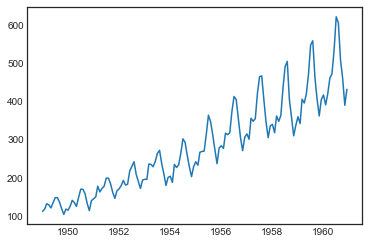

In [4]:
plt.plot(series)

In [5]:
pacfobj = pacf(series)
print(pacfobj)

[ 1.          0.95467704 -0.26527732  0.05546955  0.10885622  0.08112579
  0.00412541  0.15616955  0.10370833  0.28878144  0.20691805  0.2411297
 -0.15800498 -0.7183246  -0.08948064  0.22160591  0.13462253  0.11561572
  0.1948294   0.09665618 -0.20215868 -0.0936381 ]


In [6]:
# fit model
uselags = [1]
model = AutoReg(series, lags=uselags)
model_fit = model.fit()

In [7]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                     AutoReg(1)   Log Likelihood                -704.106
Method:               Conditional MLE   S.D. of innovations             33.277
Date:                Fri, 16 Dec 2022   AIC                           1414.212
Time:                        07:44:37   BIC                           1423.100
Sample:                    02-01-1949   HQIC                          1417.823
                         - 12-01-1960                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.7055      7.084      1.935      0.053      -0.178      27.589
#Passengers.L1     0.9589      0.023     41.106      0.000       0.913       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0428           +0.0000j            1.0428            0.0000
-----------------------------------------------------------------------------
"""

In [8]:
series.shape

(144,)

In [9]:
model_fit.predict(len(series), len(series))

1961-01-01    427.964119
Freq: MS, dtype: float64

In [10]:
model_fit.predict(len(series), len(series))

1961-01-01    427.964119
Freq: MS, dtype: float64

In [11]:
seriesb = pd.DataFrame(series.copy())

In [12]:
seriesb.columns = ['t_original']

In [13]:
def diffdf(df:"pd.DataFrame",
           var:str,
           interval:int = 1, 
           plot:bool = False) -> "pd.DataFrame":
    # internal func
    series = df[var]

    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)

    diff = pd.Series(diff)

    # new dataframe with only relevant rows to plot
    newdf = df[interval:]

    # final dataframea
    newdf[f'diff_{interval}'] = diff.values

    newdf
    
    if plot:
        plt.plot(newdf[var], color = 'blue', label = 'original');
        plt.plot(newdf[f'diff_{interval}'], color = 'green', label = f'diff_{interval}');
        plt.legend();
        plt.show();

    return newdf

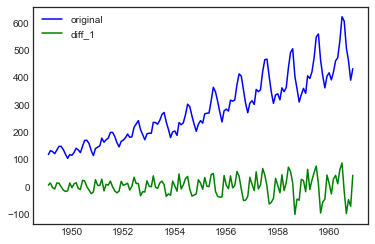

In [14]:
seriesc = diffdf(seriesb, var = "t_original", plot = True)

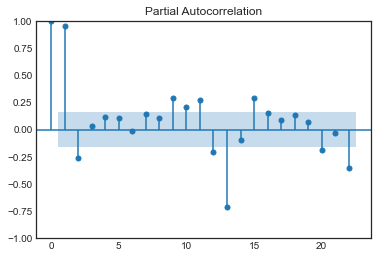

In [15]:
plot_pacf(seriesc['t_original']);

In [16]:
seriesc['t_left1'] = seriesc['t_original'].shift(periods = 1)

In [17]:
seriesc

,t_original,diff_1,t_left1
Month,,,
1949-02-01,118,6,NaN
1949-03-01,132,14,118.0
1949-04-01,129,-3,132.0
1949-05-01,121,-8,129.0
1949-06-01,135,14,121.0
...,...,...,...
1960-08-01,606,-16,622.0
1960-09-01,508,-98,606.0
1960-10-01,461,-47,508.0


In [18]:
seriesc = seriesc.dropna()
X = seriesc['t_left1'].values
y = seriesc['t_original'].values
# X_test e y_test sao os valores futuros a serem previstos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [19]:
X_train_addconst = sm.add_constant(X_train)
X_test_addconst = sm.add_constant(X_test)
lr = sm.OLS(endog = y_train, exog = X_train_addconst)
res = lr.fit()
res.params

array([12.31814697,  0.95352644])

In [20]:
y_hat = res.predict(X_test_addconst)
y_hat

array([350.82003217, 234.48980684, 199.20932866, 145.81184818,
       153.44005968, 235.44333327, 451.89383451, 406.12456553,
       191.58111716, 303.14371031, 146.76537462, 141.04421599,
       299.32960456, 427.10214715, 238.30391259, 310.77192181,
       336.51713561, 236.39685971, 125.787793  , 205.88401372,
       357.49471723, 270.72381145, 333.6565563 , 315.539554  ,
       455.70794026, 269.77028501, 231.62922752, 176.32469417,
       409.93867128])

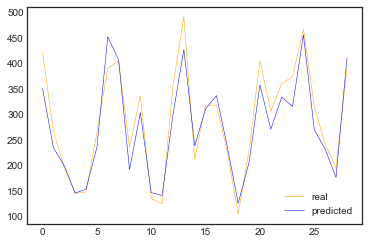

In [21]:
plt.plot(y_test, label = 'real', color = 'orange', linewidth = 0.5);
plt.plot(y_hat, label = 'predicted', color = 'blue', linewidth = 0.5);
plt.legend();
plt.show();

In [22]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1376.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           2.23e-64
Time:                        07:44:38   Log-Likelihood:                -556.49
No. Observations:                 113   AIC:                             1117.
Df Residuals:                     111   BIC:                             1122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3181      7.904      1.558      0.122      -3.344      27.981
x1             0.9535      0.026     37.093      0.000       0.903       1.004
==============================================================================
Omnibus:                        3.174   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.804
Skew:                           0.213   Prob(JB):                        0.246
Kurtosis:                       3.643   Cond. No.                         769.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
tsdata = pd.read_csv('data/ts_data.csv')
tsdata = tsdata.drop('Time',axis = 1)
tsdata.columns = tsdata.columns.str.lower()
tsdata.sample(5)

,value
9379,5.708591
4131,-0.354932
8083,1.688138
6497,2.965976
2520,4.738174


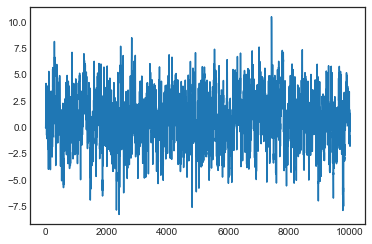

In [24]:
plt.plot(tsdata)

In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
result = adfuller(tsdata.values)
print('ADF Statistic : %f' % result[0])
print('p-value: %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]['5%']:
    print("Reject Ho - Time Series is Stationary")
else:
    print('Failed to Reject Ho - Time Series is Non-Stationary')

ADF Statistic : -22.184930
p-value: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


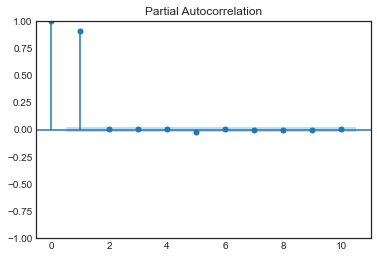

In [27]:
plot_pacf(tsdata, lags = 10);

In [28]:
tsdata['values_left1'] = tsdata['value'].shift(periods = 1)

In [29]:
tsdata

,value,values_left1
0,0.000000,NaN
1,-0.090263,0.000000
2,0.749995,-0.090263
3,1.247887,0.749995
4,0.131282,1.247887
...,...,...
9995,1.302256,0.873224
9996,0.558165,1.302256
9997,-1.401546,0.558165
9998,-1.817701,-1.401546


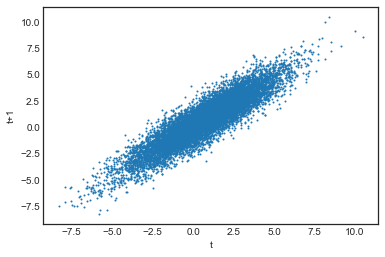

In [30]:
plt.scatter(x = tsdata['values_left1'], y = tsdata['value'], s = 1);
plt.xlabel('t');
plt.ylabel('t+1');

In [31]:
tsdata = tsdata.dropna()
y = tsdata['value'].values
X = tsdata['values_left1'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [32]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1376.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           2.23e-64
Time:                        07:44:40   Log-Likelihood:                -556.49
No. Observations:                 113   AIC:                             1117.
Df Residuals:                     111   BIC:                             1122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3181      7.904      1.558      0.122      -3.344      27.981
x1             0.9535      0.026     37.093      0.000       0.903       1.004
==============================================================================
Omnibus:                        3.174   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.204   Jarque-Bera (JB):                2.804
Skew:                           0.213   Prob(JB):                        0.246
Kurtosis:                       3.643   Cond. No.                         769.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
y_hat = res.predict(X_test_addconst)
y_hat

array([350.82003217, 234.48980684, 199.20932866, 145.81184818,
       153.44005968, 235.44333327, 451.89383451, 406.12456553,
       191.58111716, 303.14371031, 146.76537462, 141.04421599,
       299.32960456, 427.10214715, 238.30391259, 310.77192181,
       336.51713561, 236.39685971, 125.787793  , 205.88401372,
       357.49471723, 270.72381145, 333.6565563 , 315.539554  ,
       455.70794026, 269.77028501, 231.62922752, 176.32469417,
       409.93867128])

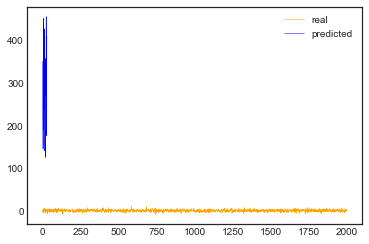

In [34]:
plt.plot(y_test, label = 'real', color = 'orange', linewidth = 0.5);
plt.plot(y_hat, label = 'predicted', color = 'blue', linewidth = 0.5);
plt.legend();
plt.show();

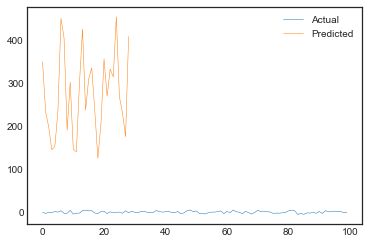

In [35]:
_last = 100
plt.plot(y_test[-_last:], label = 'Actual',linewidth = 0.5);
plt.plot(y_hat[-_last:], label = 'Predicted', linewidth = 0.5);
plt.legend();
plt.show();